In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


%matplotlib inline

In [2]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Жалобы жкх/jkh_dataset.csv')

In [4]:
df.head()

,id,текст,категория,срочность,эмоция,сущности
0,1,"В подъезде третий день мигает лампочка, глаза ...",электрика,средняя,раздражение,"подъезд, лампочка, 3 дня"
1,2,"Из крана течёт ржавая вода, чайник после этого...",вода,высокая,отвращение,"вода, кран, ржавчина"
2,3,"Ну и где наше отопление? На улице +5, а батаре...",отопление,высокая,гнев,"отопление, температура:+5"
3,4,Лифт как обычно встал. Вчера — сегодня — навер...,лифт,средняя,раздражение,лифт
4,5,Опять мусор не вывезли! Коты устроили фестивал...,мусор,высокая,отвращение,"мусор, контейнеры"


Пропсков в данных нет все колонки(кроме id) категориальные

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9160 entries, 0 to 9159
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         9160 non-null   int64 
 1   текст      9160 non-null   object
 2   категория  9160 non-null   object
 3   срочность  9160 non-null   object
 4   эмоция     9160 non-null   object
 5   сущности   9160 non-null   object
dtypes: int64(1), object(5)
memory usage: 429.5+ KB


Данные в большинстве являются сбалансированными но часть классов не хватает

In [32]:
class_labels = list(df.columns[2:-1])
class_labels

['категория', 'срочность', 'эмоция']

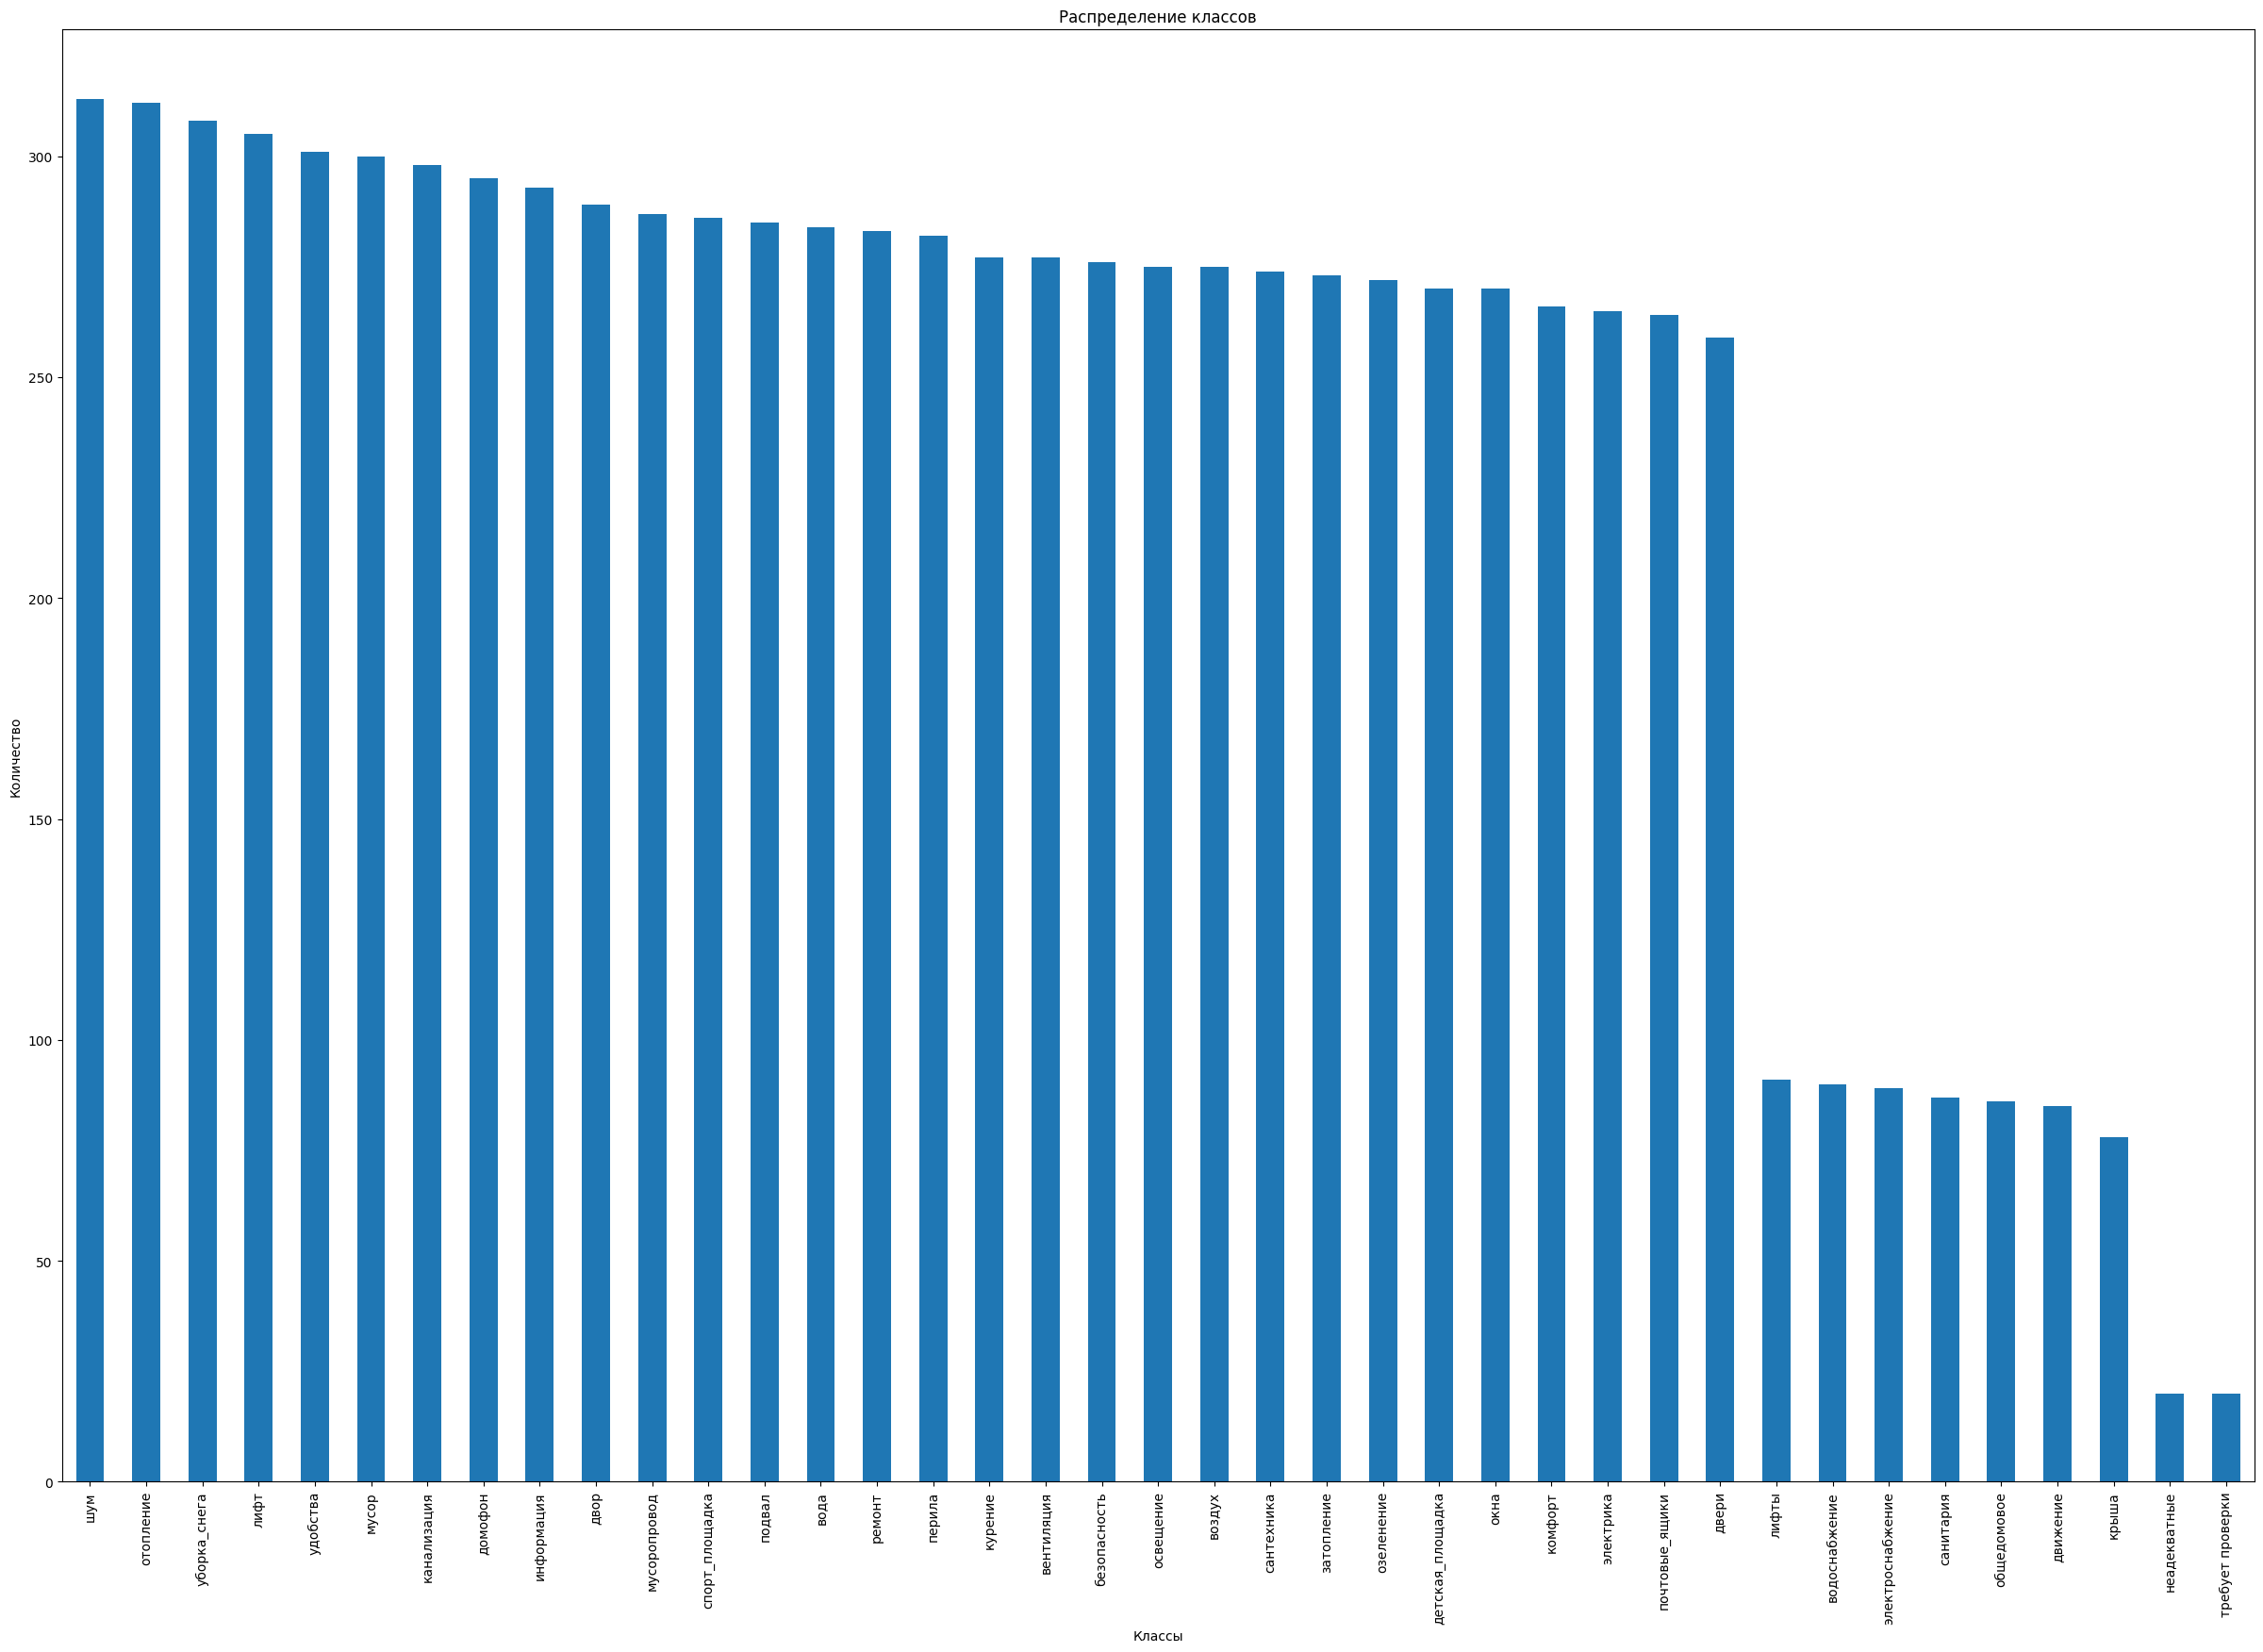

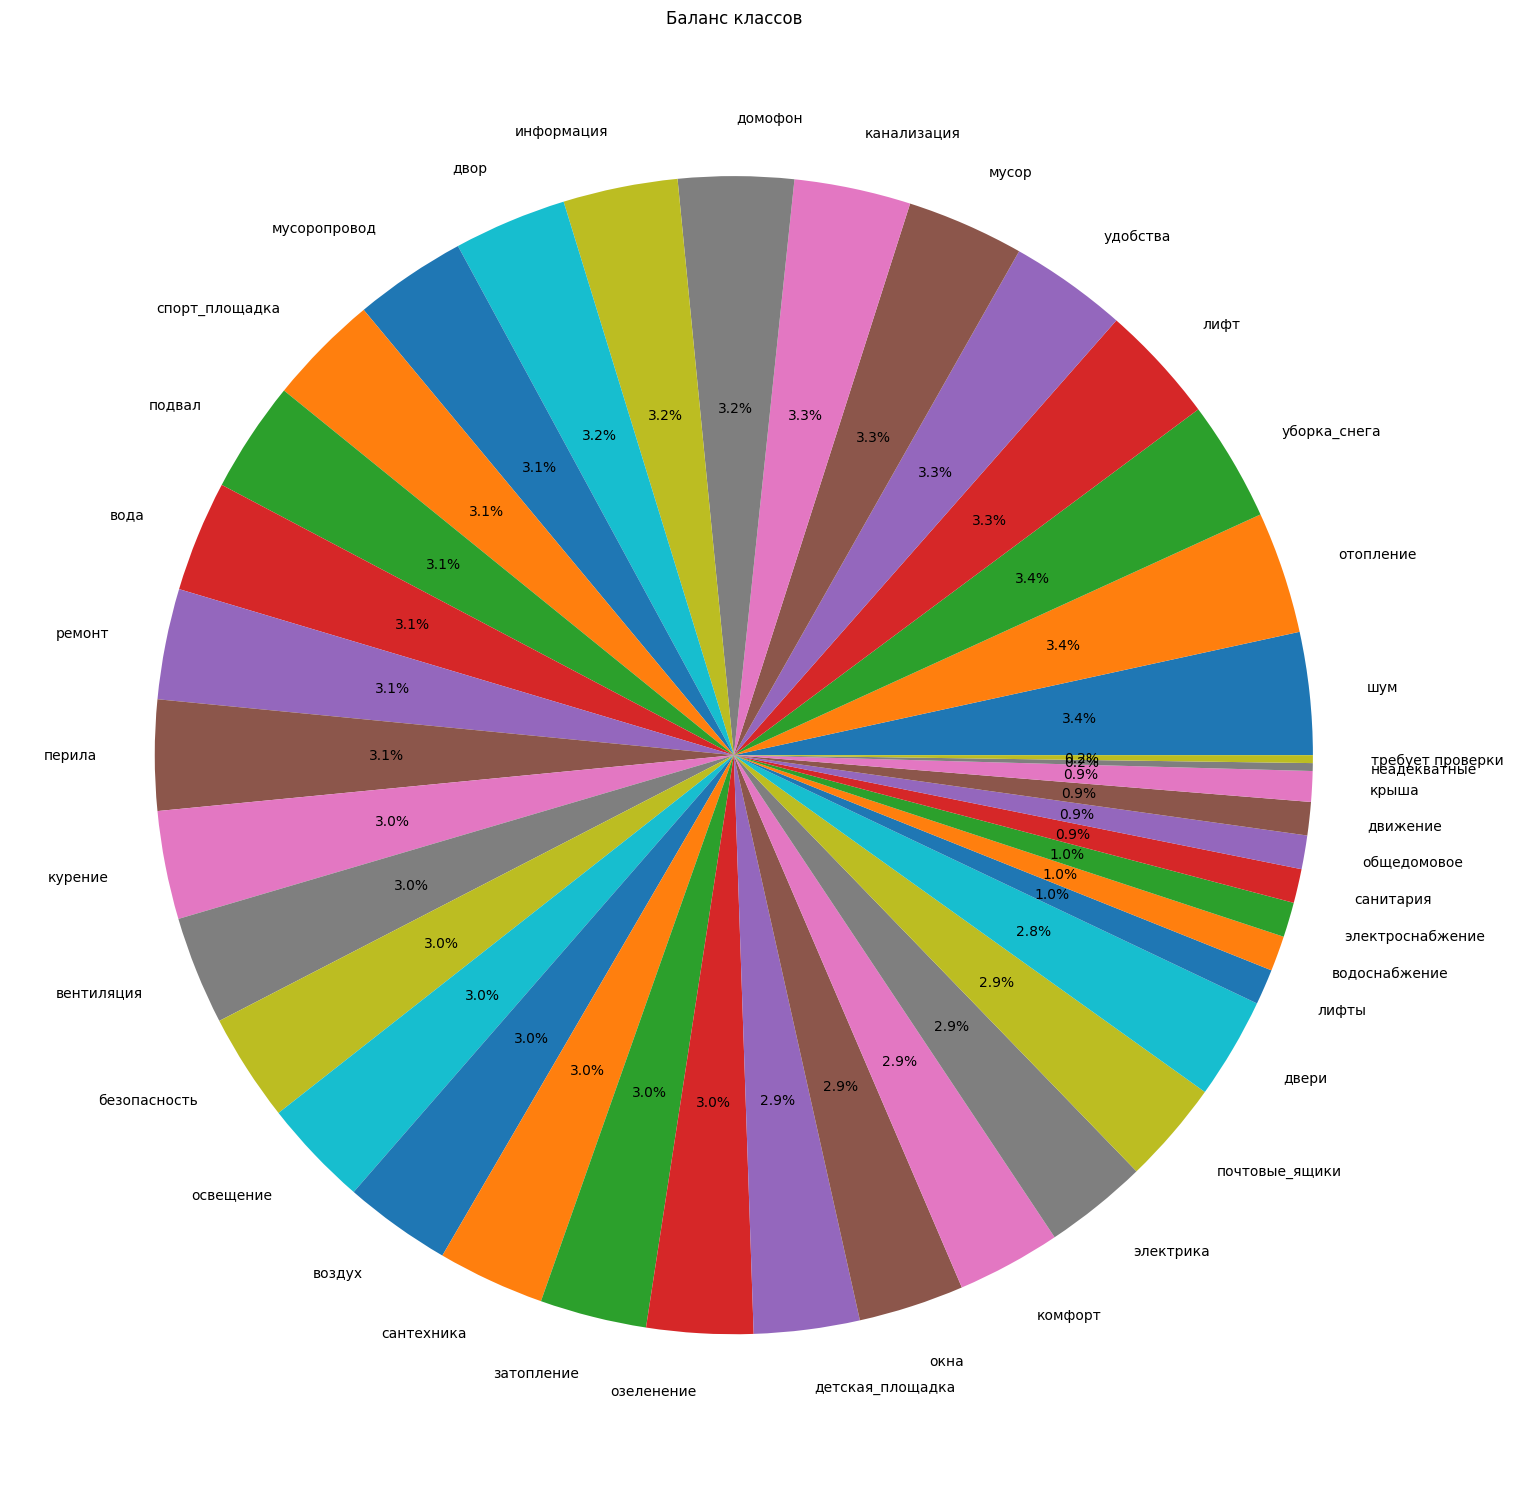

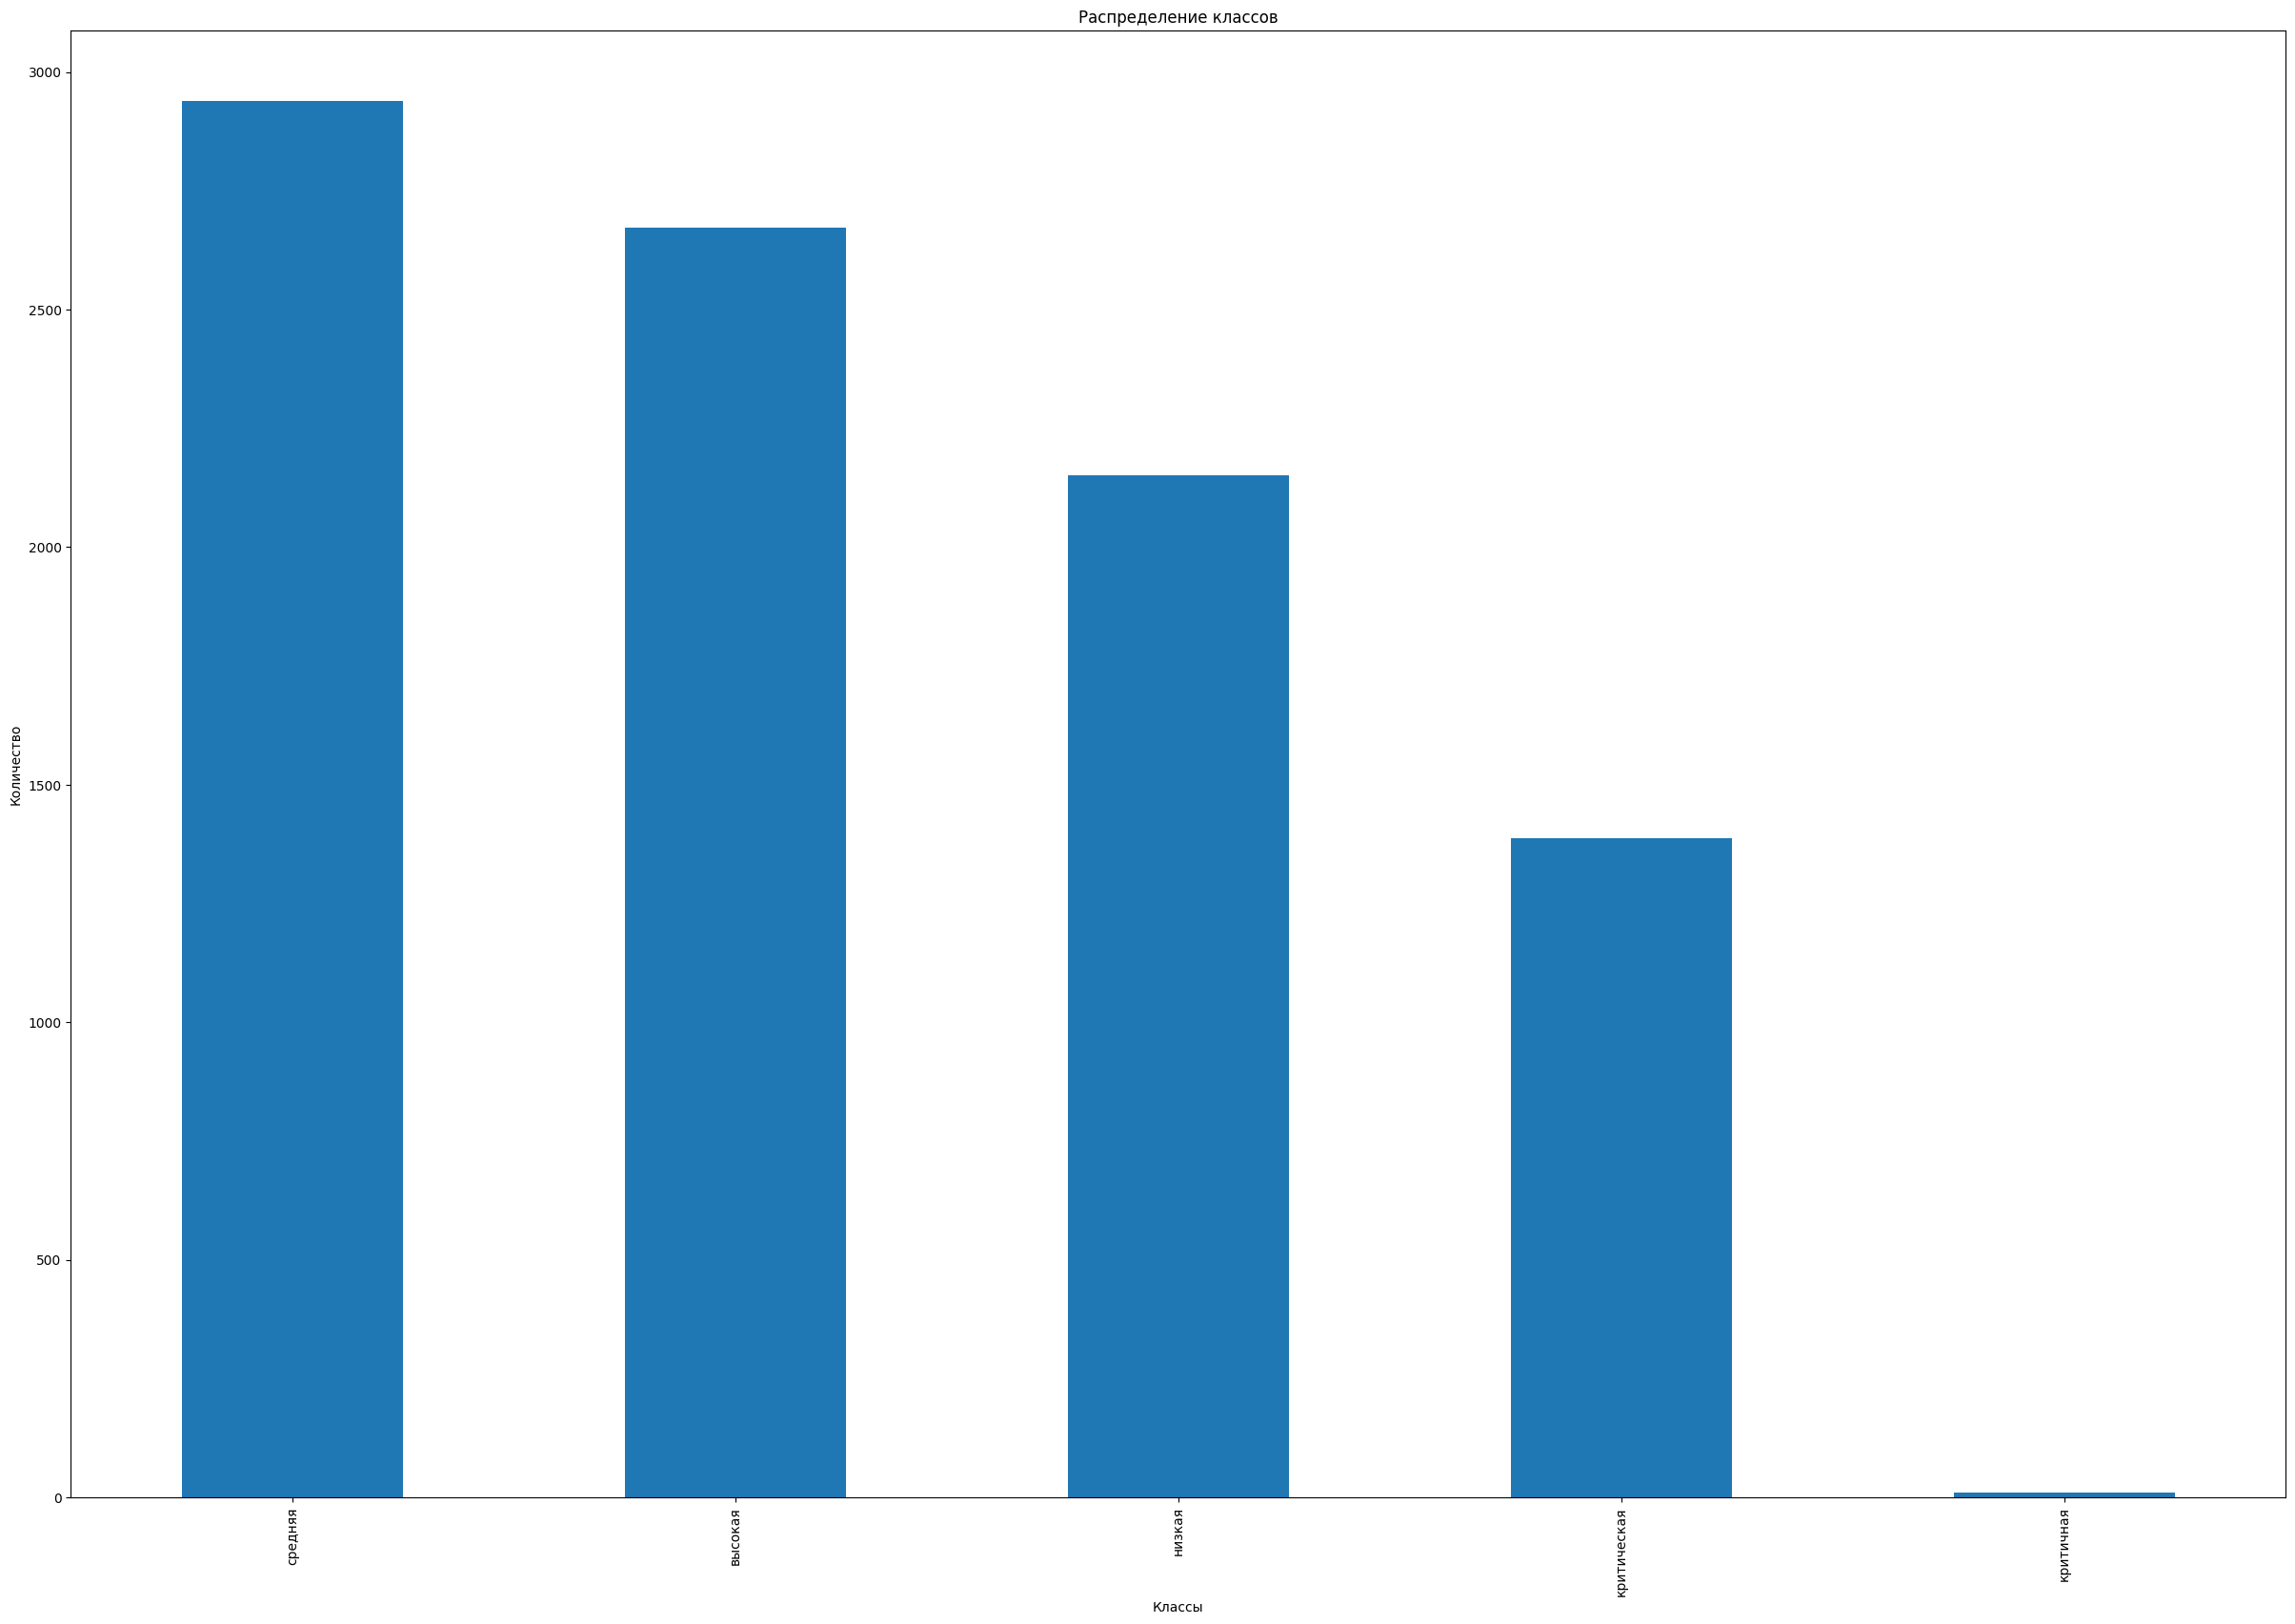

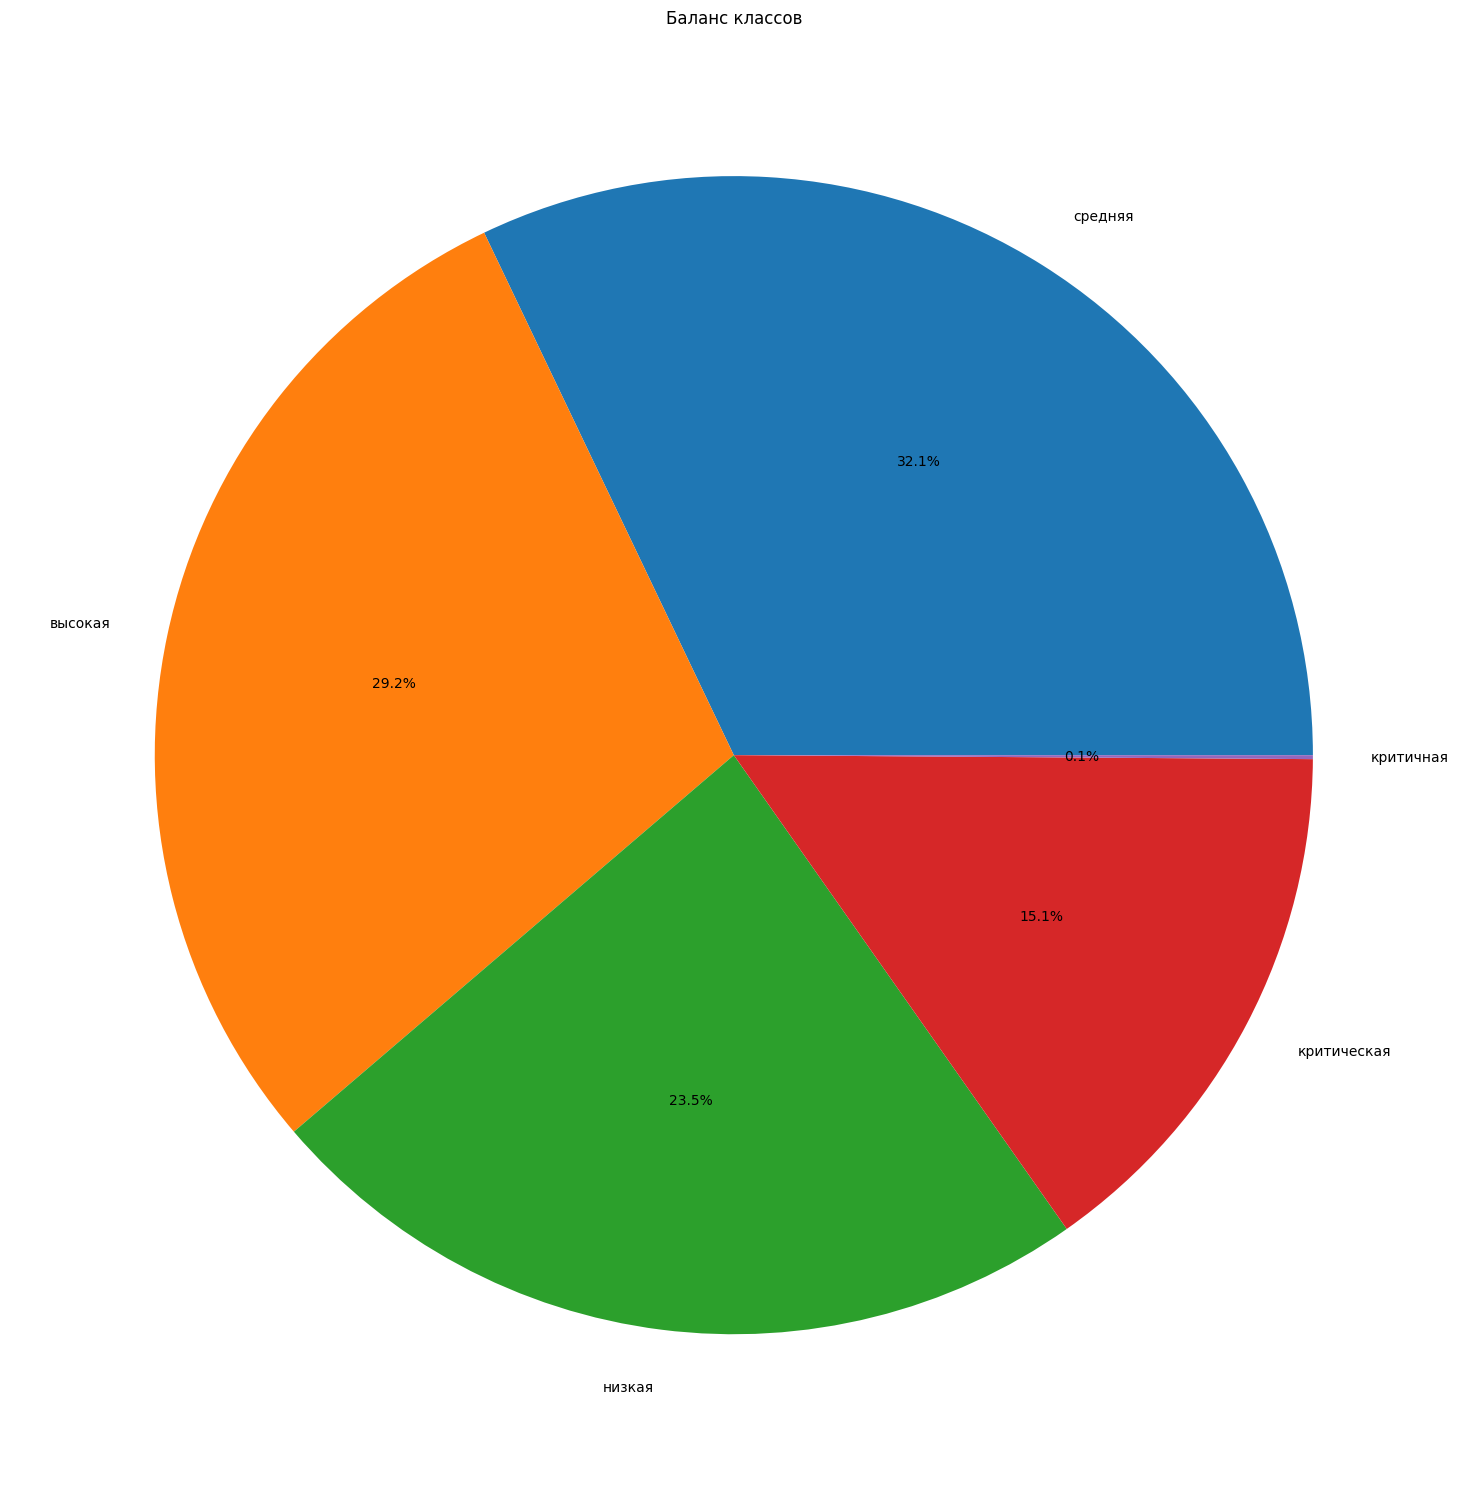

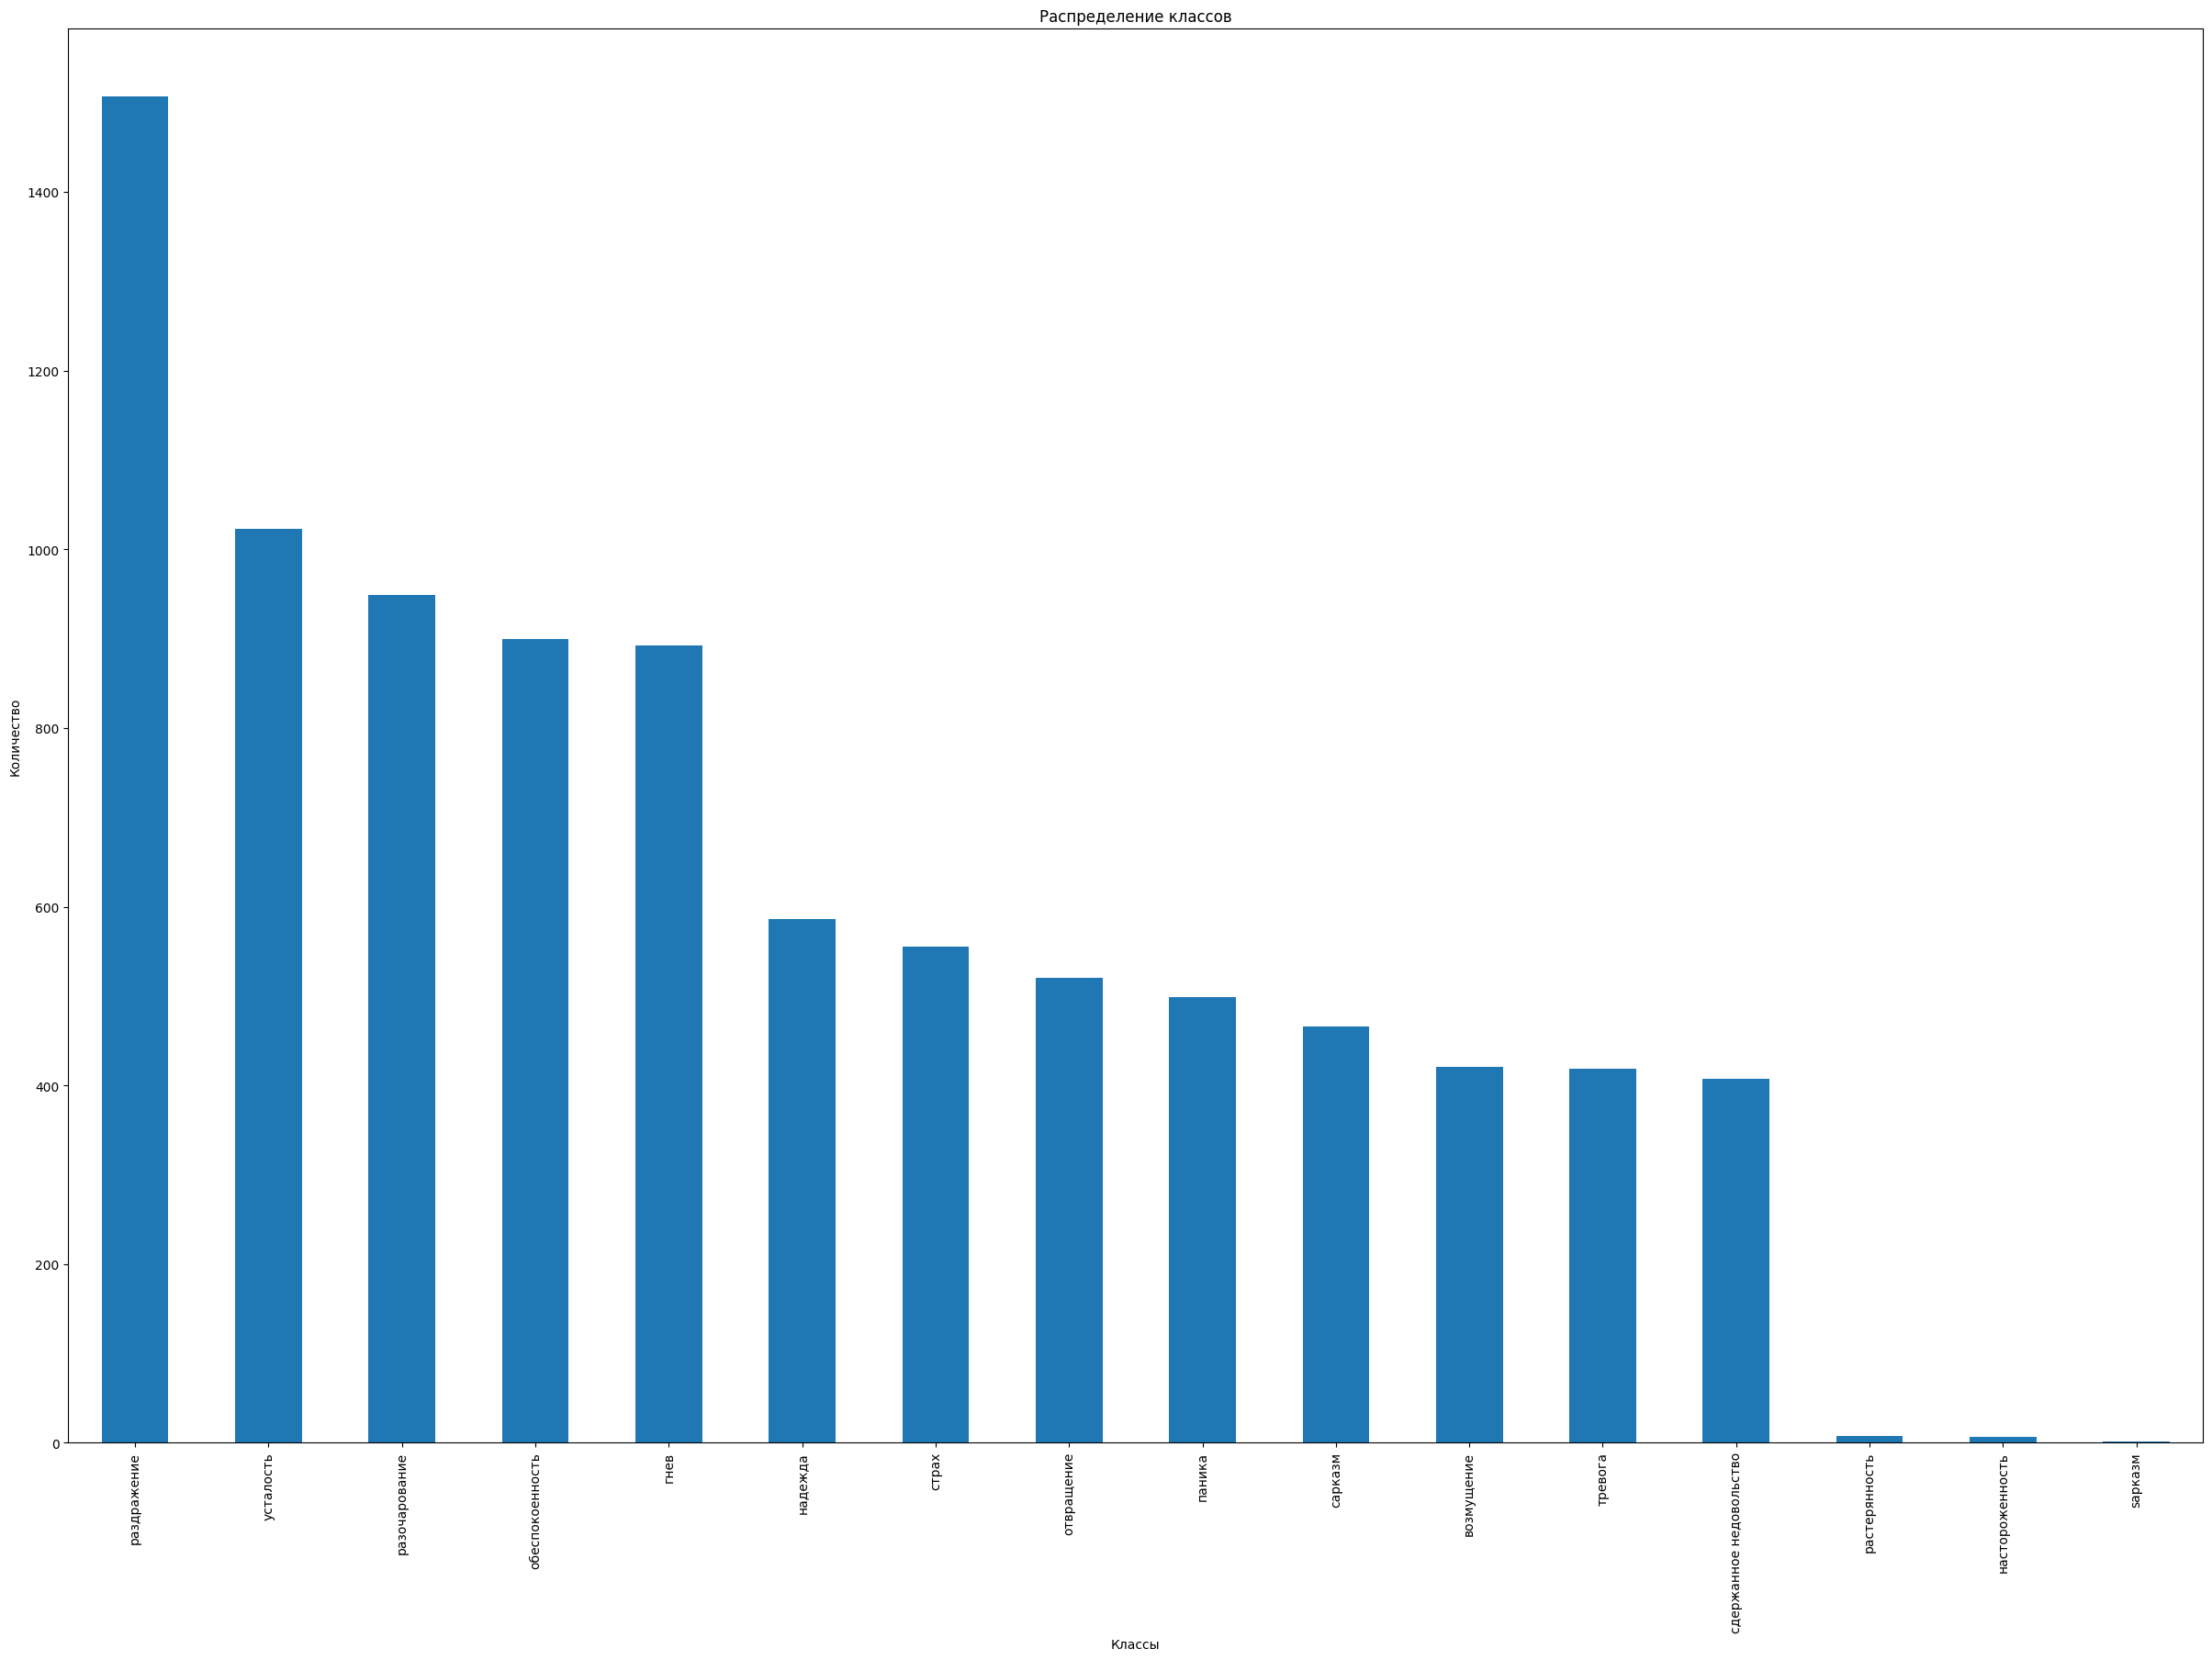

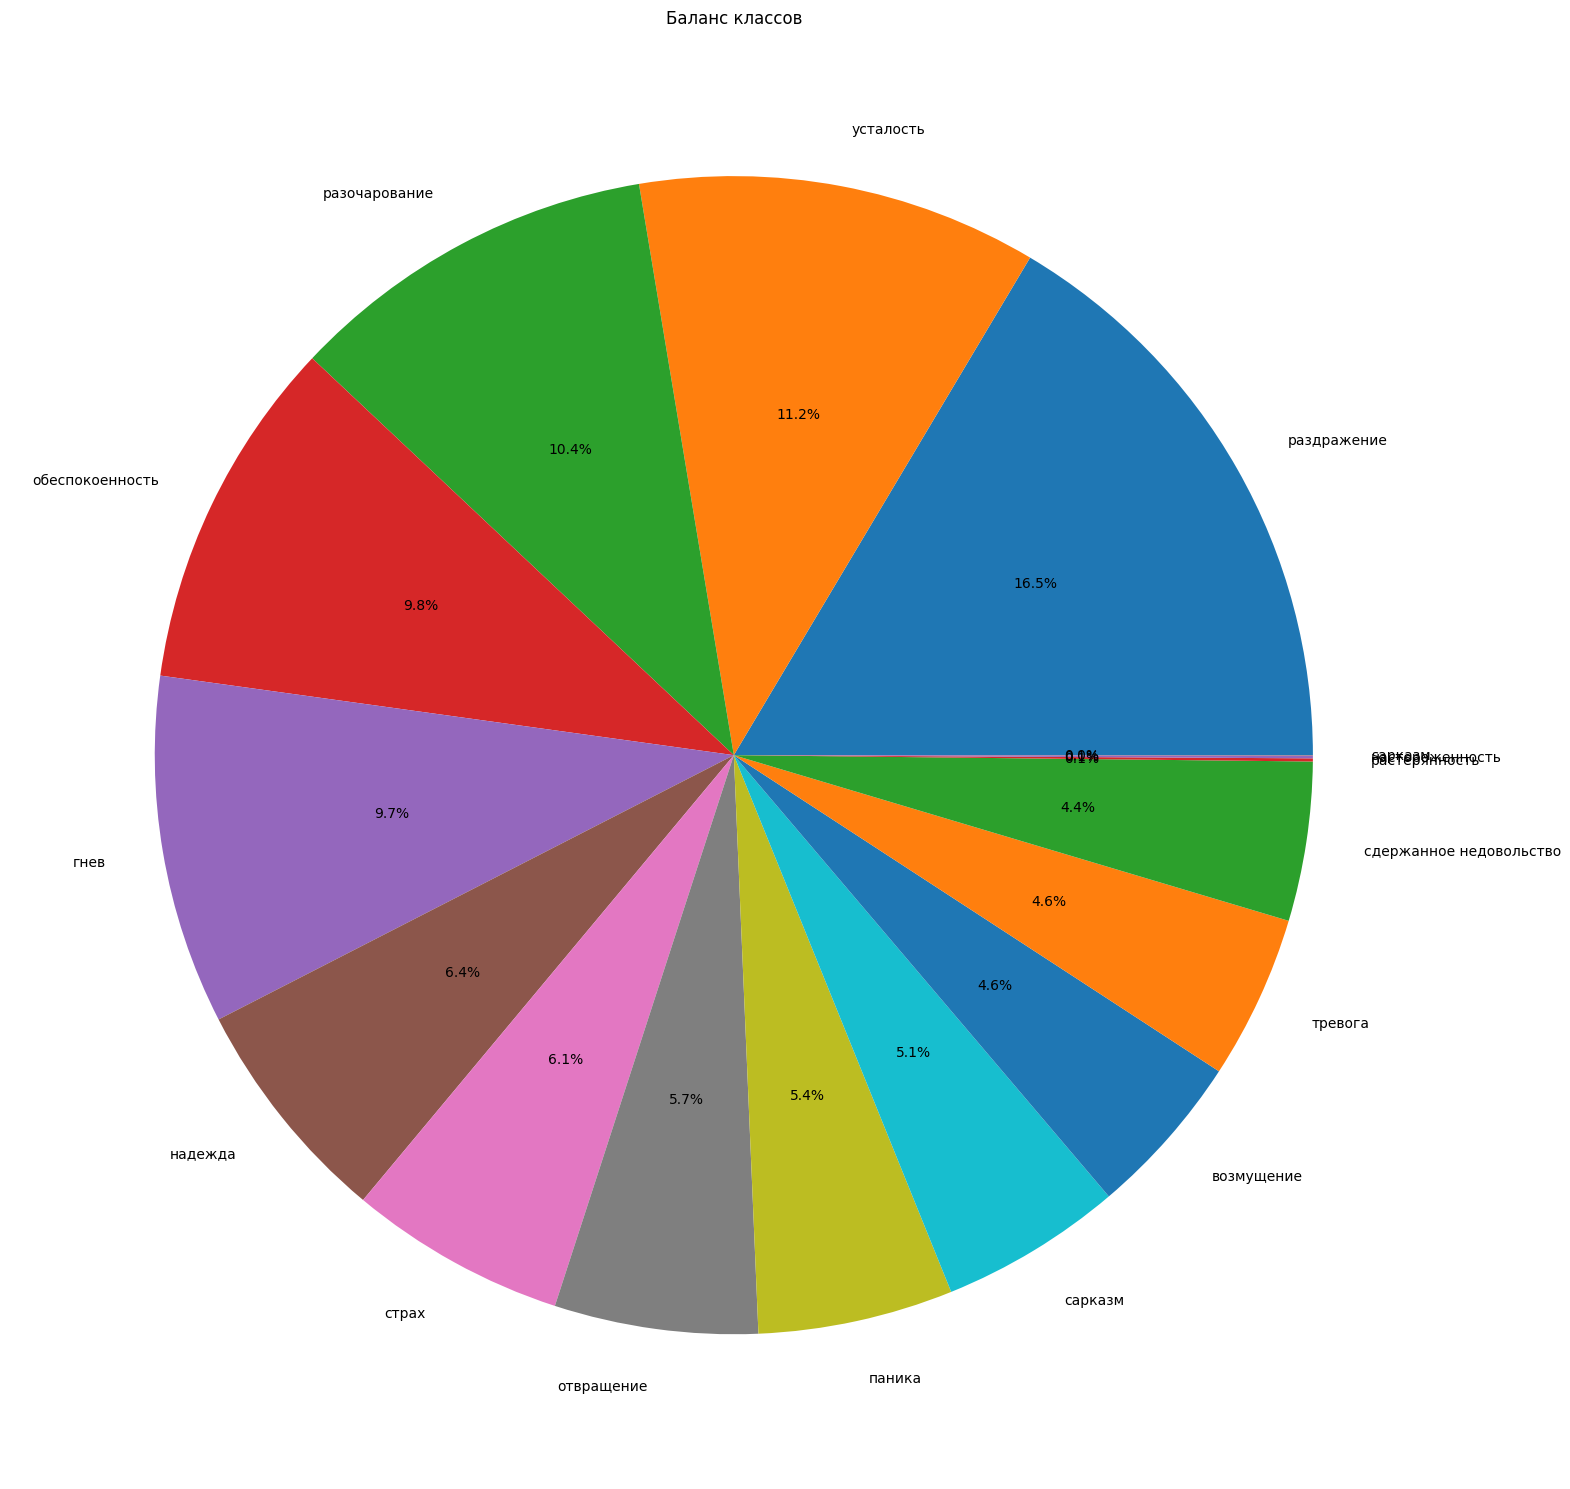

In [33]:
category = df[class_labels[0]].value_counts()
urgency = df[class_labels[1]].value_counts()
emotion = df[class_labels[2]].value_counts()

def graphics(dataset: pd.DataFrame):
  plt.figure(figsize=(30, 20))

  dataset.plot(kind='bar')
  plt.title('Распределение классов')
  plt.xlabel('Классы')
  plt.ylabel('Количество')

  plt.figure(figsize=(30, 15))
  plt.pie(dataset, labels=dataset.index, autopct='%1.1f%%')
  plt.title('Баланс классов')

  plt.tight_layout()

graphics(category)
graphics(urgency)
graphics(emotion)

Кодирование и токенизация

Пока можно попробовать предсказывать только колонку "категория"

In [37]:

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['категория'])


model_name = "cointegrated/rubert-tiny"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_encoder.classes_)
)

# токенизация
def tokenize_function(texts):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )

texts = df['текст'].tolist()
labels = df['label'].tolist()

tokenized_data = tokenize_function(texts)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.7M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Датасет для PyTorch

In [38]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

dataset = CustomDataset(tokenized_data, labels)

#  разделение
train_size = 0.8
train_dataset, eval_dataset = train_test_split(
    dataset,
    train_size=train_size,
    random_state=42
)

Обучение

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    report_to = None
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)


trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss
1,3.508100,3.518950
2,3.442200,3.510183
3,3.439600,3.544065
4,3.458900,3.548187
5,3.403100,3.566700
6,3.370700,3.609036
7,3.270000,3.626204
8,3.081800,3.649996


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument i

Тестирование и предсказание модели

In [ ]:
def predict_category(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    predicted_class_id = outputs.logits.argmax().item()
    return label_encoder.inverse_transform([predicted_class_id])[0]


test_text = "В подъезде не горит свет на лестнице"
predicted_category = predict_category(test_text)

f"Текст: {test_text}"
f"Предсказанная категория: {predicted_category}"



Сохраняем модель

In [ ]:
model.save_pretrained("./trained_model")
tokenizer.save_pretrained("./trained_model")